In [50]:
import re
import unicodedata

import pandas as pd
import numpy as np

import seaborn as sn
import matplotlib.pyplot as plt

from rake_nltk import Rake
import rake_nltk
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\juanp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
with open('data\\data_scientist.txt','r', encoding='utf-8') as f:
    info = f.readlines()

info = '\n'.join(info)
info = info.split('|----------|')
info = info[1:]

In [3]:
def count_nonempty(desc):
    counter = 0
    for d in desc.split('\n'):
        if d != '':
            counter += 1
    return counter


def drop_eeo(desc):
    if count_nonempty(desc) <= 1:
        return desc
    new_desc = []
    for d in desc.split('\n'):
        if not(('equal employment opportunity' in d) or ('equal opportunity employer' in d)):
            new_desc.append(d)
    return '\n'.join(new_desc)


def find_block(desc,ini_word,end_word):
    limits = []
    for i, line in enumerate(desc):
        if line == ini_word:
            limits.append(i)
        elif line == end_word:
            limits.append(i)
    return limits
    
    
def process_DealerPolicy(desc):
    desc = desc.split('\n')
    limits = find_block(desc,'Responsibilities','Benefits')
    desc = desc[limits[0]:limits[1]]
    return '\n'.join(desc)


def process_Addepar(desc):
    desc = desc.split('\n')
    limits = find_block(desc,'The Role','About Addepar')
    if len(limits) != 2:
        limits = find_block(desc,'Responsibilities','About Addepar')
    desc = desc[limits[0]:limits[1]]
    return '\n'.join(desc)


def process_Dice(desc):
    desc = desc.split('\n')
    return '\n'.join(desc[4:])

In [4]:
urls = []
titles = []
companies = []
locations = []
descriptions = []
basic_info = []

for tmp in info:
    tmp_information = tmp.split('\n')
    
    url = tmp_information[4]
    title = tmp_information[6]
    company = tmp_information[8]
    location = tmp_information[10]
    
    basic_info.append([title, company, location, url])
    urls.append(url)
    titles.append(title)
    companies.append(company)
    locations.append(location)
    if company == 'DealerPolicy':
        description = process_DealerPolicy('\n'.join(tmp_information[12:]))
    elif company == 'Dice':
        description = process_Dice('\n'.join(tmp_information[12:]))
    elif company == 'Addepar':
        description = process_Addepar('\n'.join(tmp_information[12:]))
    else:
        description = '\n'.join(tmp_information[12:])
        
#     descriptions.append(description)
    descriptions.append(drop_eeo(description.lower()))

In [5]:
df_offers = pd.DataFrame(basic_info, columns = ['title','company','location','url'])
df_offers

,title,company,location,url
0,Senior Cyber Supply Chain Risk Modeler/Data Sc...,Guidewire Software,United States,https://www.linkedin.com/company/9624/
1,Remote Data Scientist - Merchant Analytics,RITE AID,"Camp Hill, PA",https://www.linkedin.com/company/6913/
2,"Data Scientist (100% Remote For Now, Will Requ...",The Mom Project,"Menlo Park, CA",https://www.linkedin.com/company/10420321/
3,Data Scientist / Operations Research Scientist...,Vroom,"New York, NY",https://www.linkedin.com/company/3107677/
4,Software Engineer (Entry level),Tata Consultancy Services,"Tennessee, United States",https://www.linkedin.com/company/1353/
...,...,...,...,...
966,Software Engineer (Remote),Q² Solutions,"Columbia, MD",https://www.linkedin.com/company/10396016/
967,Kafka Software Engineer (Remote),KeyBank,"Ashland, Ohio, United States",https://www.linkedin.com/company/3252/
968,Software Engineer (Full Stack),Woflow,"San Francisco, CA",https://www.linkedin.com/company/18532450/
969,Data Scientist,Woflow,"San Francisco, CA",https://www.linkedin.com/company/18532450/


In [6]:
df_offers['company'].value_counts().head(30)

DealerPolicy                 74
Dice                         60
Addepar                      34
Docker, Inc                  32
HashiCorp                    30
Degreed                      26
Zillow                       17
Virgin Pulse                 14
HomeAdvisor                  13
Collibra                     13
Vroom                        12
Tata Consultancy Services    10
GE Healthcare                10
Mode                          9
Leidos                        8
The Mom Project               8
ClearanceJobs                 7
JW Player                     6
Clari                         6
Koch Industries               6
Wiley                         6
Securly                       6
GovernmentCIO                 6
Catalent Pharma Solutions     6
Horizontal Talent             6
Confluent                     6
LHC Group                     5
Greenway Health               5
Datapeople                    5
iboss                         5
Name: company, dtype: int64

In [9]:
df_offers[df_offers['company'] == 'DealerPolicy']['title'].value_counts()

Software Engineer - Remote    74
Name: title, dtype: int64

In [21]:
sw = stopwords.words('english') + ['long', 'descriptive', 'text', 'contains', 'technical', 'skills', 'keywords', 'things', 'see', 'rake', 'need', 'many', 'lists', 'let', 'extract']

def preprocess_text(text, sw):
    wnl = nltk.WordNetLemmatizer()
    text = (unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8', 'ignore').lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [word for word in words if word not in sw]

In [17]:
n = 1
data_frames = []

for desc in descriptions:
    words = preprocess_text(desc, sw)
    data_frames.append(pd.Series(list(set(list(nltk.ngrams(words,n))))).value_counts().reset_index().rename(columns={'index': 'n-gram', 0: 'count'}))
    
df = pd.concat(data_frames).groupby('n-gram').sum().sort_values(by = 'count', ascending = False)

for i, row in df.head(1000).iterrows():
    print(row['count'], end = ' ')
    print(*i, sep = ' ')

936 experience
806 work
745 team
725 software
721 years
685 working
682 data
675 development
614 design
609 new
602 engineering
578 build
556 tools
553 strong
548 business
544 solutions
531 ability
528 role
520 code
514 building
511 company
510 science
510 using
506 teams
494 best
476 computer
472 including
469 engineer
467 support
466 develop
461 product
458 technologies
457 technology
456 services
455 responsibilities
454 environment
453 products
449 us
443 knowledge
442 applications
441 understanding
438 degree
430 systems
418 requirements
418 time
410 developing
407 programming
406 sql
404 communication
401 platform
396 practices
394 across
391 help
386 python
385 learn
377 based
374 qualifications
367 benefits
364 job
362 quality
362 provide
361 customers
359 remote
358 people
358 looking
350 management
346 learning
345 cloud
345 preferred
340 problems
340 required
333 3
332 performance
330 process
328 information
325 health
325 maintain
322 opportunity
321 application
321 web
320

In [22]:
n = 2
data_frames = []

for desc in descriptions:
    words = preprocess_text(desc, sw)
    data_frames.append(pd.Series(list(set(list(nltk.ngrams(words,n))))).value_counts().reset_index().rename(columns={'index': 'n-gram', 0: 'count'}))
    
df = pd.concat(data_frames).groupby('n-gram').sum().sort_values(by = 'count', ascending = False)

for i, row in df.head(1000).iterrows():
    print(row['count'], end = ' ')
    print(*i, sep = ' ')

414 computer science
355 years experience
302 3 years
287 bachelors degree
279 experience working
257 best practices
242 software engineer
226 experience building
196 2 years
192 software development
181 dental vision
176 team members
174 ability work
161 design develop
158 work experience
151 preferred qualifications
149 code reviews
145 degree computer
144 related field
143 development experience
142 data science
139 sexual orientation
138 experience data
138 learn new
136 software engineering
132 years professional
132 machine learning
130 national origin
128 web applications
127 engineering team
126 gender identity
124 veteran status
123 prior experience
120 experience developing
119 race color
118 join us
116 microsoft azure
114 data engineering
114 ability learn
113 science equivalent
111 work environment
111 job description
110 parental leave
109 experience using
109 color religion
107 deep understanding
107 software solutions
107 5 years
107 user experience
106 development oper

30 interview communication
30 interview engineering
30 leaves absence
30 cloud clouds
30 mutual tls
30 opportunities product
30 interview systems
30 integrations envoys
30 hashicorp consul
30 serviceoriented intentions
30 tooling deploy
30 team prior
30 usability challenges
30 demands role
30 academic computer
30 community participate
30 hashicorp used
30 written documents
30 also announced
30 applicable final
30 automate network
30 complexity barriers
30 conversation engineering
30 tao hashicorp
30 worked infrastructure
30 type without
30 hcp selfservice
30 consider experience
30 communicate cover
30 absence compensation
30 automate infrastructure
30 checking evolved
30 complex systems
30 consul service
30 identify data
30 discussions product
30 consul aws
30 managers customers
30 specifics past
30 manager team
30 members perform
30 best accommodate
30 improving build
30 steps based
30 ruby rails
30 organizational demands
30 well given
30 running applications
30 solves development
30 

In [23]:
n = 3
data_frames = []

for desc in descriptions:
    words = preprocess_text(desc, sw)
    data_frames.append(pd.Series(list(set(list(nltk.ngrams(words,n))))).value_counts().reset_index().rename(columns={'index': 'n-gram', 0: 'count'}))
    
df = pd.concat(data_frames).groupby('n-gram').sum().sort_values(by = 'count', ascending = False)

for i, row in df.head(1000).iterrows():
    print(row['count'], end = ' ')
    print(*i, sep = ' ')

130 degree computer science
126 3 years experience
108 race color religion
108 computer science equivalent
100 medical dental vision
96 ability learn new
94 regard race color
94 without regard race
91 requirements bachelors degree
91 sexual orientation gender
91 2 years experience
88 orientation gender identity
87 3 years professional
85 bachelors degree computer
81 computer science related
80 design develop test
79 new tools technologies
77 learn new tools
77 equivalent 3 years
76 science equivalent 3
75 professional work experience
75 progressive web applications
75 contribute code reviews
75 prior experience building
75 responsive progressive web
75 processes best practices
74 platforms design develop
74 engineering aptitude ability
74 core products supporting
74 concentration computer science
74 problemsolving exposure cloud
74 andor experience c
74 degree concentration computer
74 clientsoftware using modern
74 engineering discipline highly
74 eventdriven software architectures
74

30 team would joining
30 way provide sample
30 operations security challenges
30 infrastructures running applications
30 mix match aws
30 add remove steps
30 hashicorp largely remote
30 hashicorp fastgrowing startup
30 program mostly go
30 match aws microsoft
30 opportunity committed building
30 hashicorp embraces diversity
30 contributing team committed
30 critical aspect work
30 enable secure connectivity
30 supporting software write
30 understand network topologies
30 well onpremises environments
30 hashicorp draws role
30 value topnotch collaboration
30 principles interact value
30 principles product development
30 automate infrastructure cloud
30 edge deployments interface
30 automate network configurations
30 performance security complexity
30 following panel code
30 hashicorp hashicorp fastgrowing
30 way manage move
30 certificate management mutual
30 studies discussions product
30 following new developments
30 bare metal datacenter
30 ability deliver new
30 barriers adoption pr

In [15]:
r = Rake(
    ranking_metric = rake_nltk.Metric.DEGREE_TO_FREQUENCY_RATIO,
    stopwords = stopwords.words('english') + ['long', 'descriptive', 'text', 'contains', 'technical', 'skills', 'keywords', 'things', 'see', 'rake', 'need', 'many', 'lists', 'let', 'extract']
)

all_descriptions = '\n'.join(descriptions)
r.extract_keywords_from_text(all_descriptions)

phrases_scores = r.get_ranked_phrases_with_scores()

for score, phrase in phrases_scores[:2000]:
    print(score, phrase)

200.5437531894729 manager recruitment 116 village blvd bull suite 200 bull princeton bull new jersey bull 08540 direct office ext 104 httpswww
152.50117283950618 eeoc poster eeoc gina supplement ofccp eeo supplement pay transparency nondiscrimination search firm representatives please read carefully merck
134.35105756973007 itil process implementation experience supporting dhs mission space desired certifications servicenow automated test framework fundamentals servicenow system administrator servicenow implementation specialist servicenow application developer governmentcio
103.85283524257406 c ++ 14 software engineering experience architectural patterns python mqtt linux json git vs code docker zephyr soft
98.50361070801694 nacnx msja job description job id :- 13285380 job title :- software engineer location
97.58552217436089 paid volunteer hours diversity alliance resource groups employee stock purchase program tuition reimbursement charitable gift matching job required equipment
91

19.1810844086289 configuration develop flexible automation solutions
19.18076060574082 using various programming languages depending
19.1793599988316 automated test framework working knowledge
19.177266218533013 commercial life sciences data sets
19.163747049361845 integration systems like jenkins familiarity
19.158835027158894 haves apache airflow experience typescript
19.1546041439726 meet every requirement – transferrable
19.154551866478567 remote embedded c ++ developer
19.154054054054054 catered lunch every friday
19.15243894056394 common machine learning programming languages
19.151940119006362 python develop data conversion pipelines
19.1501976284585 diverse product portfolio includes mempool explorer
19.149182916239045 shop recommendations team leverages personalization algorithms
19.139270592245964 required ): experience working remotely
19.133936993020185 experts span 230 staff drawn
19.132086853256816 create production grade predictive models
19.13001877374737 experience man

In [59]:
keyword_list = [
    'sql','python','aws','java','c','azure','javascript','react','docker','api','apis','rest','restful',
    'kubernetes','git','github','spark','saas','google','tableau','ajax','r','css','nodejs','ruby','linux'
]

n = 1
data_frames = []

for desc in descriptions:
    words = preprocess_text(desc, sw)
    data_frames.append(pd.Series(list(set(list(nltk.ngrams(words,n))))).value_counts().reset_index().rename(columns={'index': 'n-gram', 0: 'count'}))
    
df = pd.concat(data_frames).groupby('n-gram').sum().sort_values(by = 'count', ascending = False)
df = df.reset_index()
df['n-gram'] = df['n-gram'].apply(lambda x: x[0])
df_red = df[df['n-gram'].isin(keyword_list)]

for i, row in df_red.iterrows():
    print(row['count'], row['n-gram'])
    
df_red = df_red.rename(columns = {'n-gram':'keyword'})

406 sql
386 python
296 aws
260 java
224 apis
213 azure
211 react
205 c
203 javascript
163 rest
144 docker
143 api
140 kubernetes
137 git
106 spark
101 saas
85 google
85 tableau
81 ajax
78 r
62 css
58 restful
57 nodejs
52 ruby
52 linux
52 github


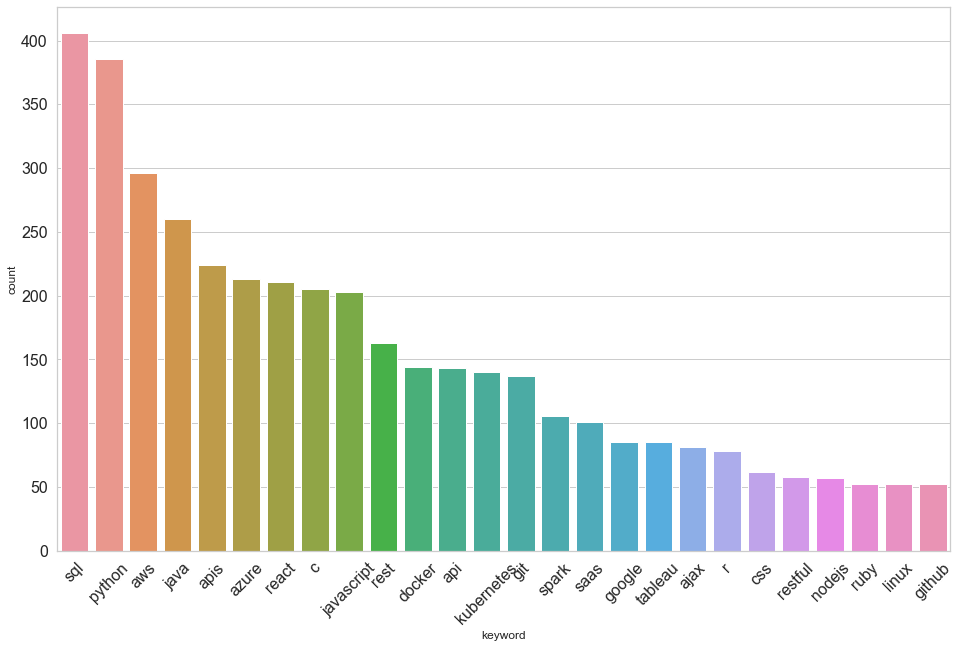

In [60]:
fig, ax = plt.subplots(figsize = (16,10))

ax = sns.barplot(x="keyword", y="count", data=df_red)
for item in ax.get_xticklabels():
    item.set_rotation(45)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);